In [270]:
import os
import time
import pandas as pd
import numpy as np
import numpy.random as npr
import copy
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from scipy.special import digamma, loggamma
from scipy.sparse import csr_matrix
from typing import List, Dict, Tuple, Set, Optional

In [269]:
def log_sum_exp(vec):
    vec_max = np.max(vec, axis=0)
    exp_vec = np.exp(vec - vec_max)
    sum_exp_vec = np.sum(exp_vec)
    log_sum_exp = np.log(sum_exp_vec) + vec_max
    return log_sum_exp

def init_variational_params(documents, K):
    N, V = documents.shape
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for document in documents:
        M = np.sum((document > 0).astype("int32"))
        document_PHI = np.ones((M, K))
        document_PHI = document_PHI / K
        PHI.append(document_PHI)
        
    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, documents, nonzero_idxs, K):
    ELBO = 0
    N, _ = documents.shape

    E_log_p_BETA = np.sum((ETA-1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))))
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum((ALPHA-1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))))
    ELBO += E_log_p_THETA

    E_log_p_x_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_p_x_z += document[idx] * np.sum(PHI[i][word_idx] * (digamma(GAMMA[i])-digamma(np.sum(GAMMA[i])))) \
                + document[idx] * np.sum(PHI[i][word_idx] * (digamma(LAMBDA[:, idx])-digamma(np.sum(LAMBDA, axis=1))))
            word_idx += 1
    ELBO += E_log_p_x_z

    E_log_q_BETA = np.sum(-loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
        - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_BETA

    E_log_q_THETA = np.sum(-loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1))
    ELBO += E_log_q_THETA

    E_log_q_z = 0
    for i in range(N):
        document = documents[i]
        nonzero_idx = nonzero_idxs[i]
        word_idx = 0
        for idx in nonzero_idx:
            E_log_q_z += -document[idx] * np.sum(PHI[i][word_idx] * np.log(PHI[i][word_idx]))
            word_idx += 1
    ELBO += E_log_q_z

    return ELBO

In [283]:
def simulate_LDA(N, avg_doc_length, K, V, ETA=0.1, ALPHA=0.5, rs_int=np.random.randint(low=0, high=100)):
    rs = npr.RandomState(rs_int) 
    BETA = rs.dirichlet(np.full(V, ETA), size=K)
    THETA = rs.dirichlet(np.full(K, ALPHA), size=N)
    doc_lengths = rs.poisson(avg_doc_length, size=N)
    
    row_idxs = []
    col_idxs = []
    values = []
    nonzero_idxs = []

    for i in range(N):
        doc_word_counts = np.zeros(V)
        for _ in range(doc_lengths[i]):
            z_ij = rs.choice(K, p=THETA[i])
            x_ij = rs.choice(V, p=BETA[z_ij])
            doc_word_counts[x_ij] += 1
        doc_nonzero = np.nonzero(doc_word_counts)[0]
        doc_nonzero = np.array(sorted(doc_nonzero))
        nonzero_idxs.append(doc_nonzero)

        row_idxs.extend([i] * len(doc_nonzero))
        col_idxs.extend(doc_nonzero)
        values.extend(doc_word_counts[doc_nonzero])
    documents = csr_matrix((values, (row_idxs, col_idxs)), shape=(N, V)).toarray()
    
    return documents, nonzero_idxs, BETA, THETA

In [289]:
documents, nonzero_idxs, _, _ = simulate_LDA(100, 100, 5, 1000)
LAMBDA, GAMMA, PHI = init_variational_params(documents, K=5)
compute_ELBO(LAMBDA, GAMMA, PHI, documents, nonzero_idxs, K=5)

np.float64(-102262.16796881869)

In [ ]:
def generate_data(N: int, M: List[int], K: int, V: int, ETA: float = 0.1, ALPHA: float = 0.5) -> Tuple[List[np.ndarray], np.ndarray]:
    rs = np.random.RandomState(np.random.randint(low=0, high=100))
    BETA = rs.dirichlet(np.full(V, ETA), size=K)
    X = []

    for i in range(N):
        THETA = rs.dirichlet(np.full(K, ALPHA), size=N)
        x = []
        for _ in range(M[i]):
            z_ij = rs.choice(K, p=THETA[i])
            x_ij = rs.choice(V, p=BETA[z_ij])
            x.append(x_ij)
        X.append(np.array(x))
    return X, BETA


Initial ELBO: -1158553.470187777

Iteration 0


Updating LAMBDA: 100%|██████████| 500/500 [00:00<00:00, 9523.85it/s]


Current ELBO: -311251.8174 | Change in ELBO: 847301.65279

Iteration 1


Updating LAMBDA: 100%|██████████| 500/500 [00:00<00:00, 9573.85it/s]


Current ELBO: -311251.8174 | Change in ELBO: -0.00000



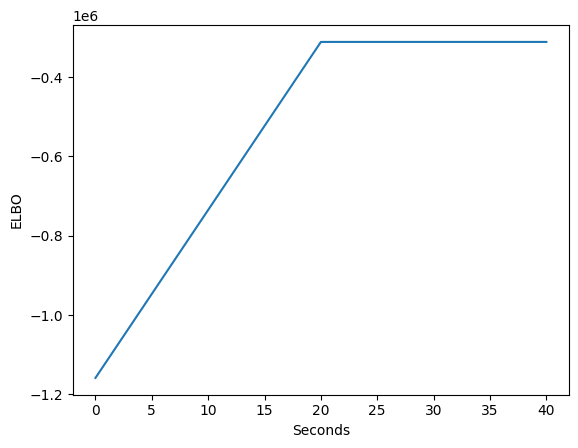

In [265]:
def compute_ELBO(X: List[np.ndarray], LAMBDA: np.ndarray, GAMMA: np.ndarray, PHI: List[np.ndarray]) -> float:
    ELBO = 0

    E_log_p_BETA = np.sum((ETA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))))
    ELBO += E_log_p_BETA

    E_log_p_THETA = np.sum((ALPHA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))))
    ELBO += E_log_p_THETA

    E_log_p_z_x = 0
    for i, x in enumerate(X):
        for j, x_ij in enumerate(x):
            E_log_p_z_x += np.sum(
                PHI[i][j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])) + digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA, axis=1)))
            )
    ELBO += E_log_p_z_x

    E_q_log_BETA = np.sum(-loggamma(np.sum(LAMBDA, axis=1)) + np.sum(loggamma(LAMBDA), axis=1) \
                        - np.sum((LAMBDA - 1) * (digamma(LAMBDA) - digamma(np.sum(LAMBDA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_BETA

    E_q_log_THETA = np.sum(-loggamma(np.sum(GAMMA, axis=1)) + np.sum(loggamma(GAMMA), axis=1) \
                        - np.sum((GAMMA - 1) * (digamma(GAMMA) - digamma(np.sum(GAMMA, axis=1, keepdims=True))), axis=1)
    )
    ELBO += E_q_log_THETA

    E_log_q_z = 0
    for i, x in enumerate(X):
        for j, x_ij in enumerate(x):
            E_log_q_z += -np.sum(PHI[i][j] * np.log(PHI[i][j] + 1e-100))
    ELBO += E_log_q_z

    return ELBO

def update_variational_params(X: List[np.ndarray], LAMBDA: np.ndarray, GAMMA: np.ndarray, PHI: List[np.ndarray],
                              N: int, M: List[int], K: int, V: int) -> Tuple[np.ndarray, np.ndarray, List[np.ndarray]]:
    PHI = [np.zeros(shape=(len(x), K)) for x in X]
    GAMMA = np.full(shape=(N, K), fill_value=ALPHA)
    for i in tqdm(range(N), desc="Updating PHI and GAMMA"):
        for j in range(M[i]):
            x_ij = X[i][j]
            exp_propto = np.zeros(shape=K)
            for k in range(K):
                exp_propto[k] = np.exp(digamma(LAMBDA[k, x_ij]) - digamma(np.sum(LAMBDA[k])) + digamma(GAMMA[i, k]) - digamma(np.sum(GAMMA[i])))
            PHI[i][j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] += np.sum(PHI[i][:, k])

    LAMBDA = np.full(shape=(K, V), fill_value=ETA)
    for i, x in enumerate(tqdm(X, desc="Updating LAMBDA")):
        for j, x_ij in enumerate(x):
            LAMBDA[:, x_ij] += PHI[i][j]
        # for k in range(K):
        #     np.add.at(LAMBDA[k], x, PHI[i][:, k])
    
    return LAMBDA, GAMMA, PHI

tol = 1e-5
prev_ELBO = -np.inf
iteration = 0
ELBOs = []

start = time.time()
LAMBDA, GAMMA, PHI = initialize_variational_params(X, N, K, V)
ELBOs.append(compute_ELBO(X, LAMBDA, GAMMA, PHI))
print(f"Initial ELBO: {ELBOs[0]}\n")
curr_ELBO = ELBOs[0]

while np.abs(curr_ELBO - prev_ELBO) > tol:
    print(f"Iteration {iteration}")
    prev_ELBO = curr_ELBO
    LAMBDA, GAMMA, PHI = update_variational_params(X, LAMBDA, GAMMA, PHI, N, M, K, V)
    curr_ELBO = compute_ELBO(X, LAMBDA, GAMMA, PHI)
    print(f"Current ELBO: {curr_ELBO:.4f} | Change in ELBO: {curr_ELBO - prev_ELBO:.5f}\n")

    ELBOs.append(curr_ELBO)
    iteration += 1

stop = time.time()

plt.xlabel("Seconds")
plt.ylabel("ELBO")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
plt.plot(np.linspace(0, float(stop-start), len(ELBOs)), ELBOs)

In [260]:
print(f"Initial ELBO: {curr_ELBO}")
for i in range(5):  # Perform a few manual updates
    LAMBDA, GAMMA, PHI = update_variational_params(X, LAMBDA, GAMMA, PHI, N, M, K, V)
    curr_ELBO = compute_ELBO(X, LAMBDA, GAMMA, PHI)
    print(f"Iteration {i + 1}: ELBO = {curr_ELBO}")

Initial ELBO: -311630.369410053


Updating LAMBDA: 100%|██████████| 500/500 [00:00<00:00, 9504.90it/s]


Iteration 1: ELBO = -311630.3694100529


Updating LAMBDA: 100%|██████████| 500/500 [00:00<00:00, 8023.57it/s]


Iteration 2: ELBO = -311630.3694100529


Updating PHI and GAMMA:  67%|██████▋   | 337/500 [00:12<00:05, 27.41it/s]


KeyboardInterrupt: 

In [266]:
LAMBDA_norm = LAMBDA / np.sum(LAMBDA, axis=1, keepdims=True)
np.log(LAMBDA_norm[0])

array([ -6.6924601 ,  -7.77412825,  -6.77650079,  -6.84922045,
        -6.92764588,  -6.94825242,  -6.84922045,  -6.33110485,
        -5.87822155,  -7.15574766,  -6.81219975,  -7.77412825,
        -6.57115452,  -7.41788136,  -6.70871269,  -8.04561627,
        -7.35340528,  -6.20466074,  -6.50219021,  -6.43767668,
        -6.60012946,  -6.96929254,  -8.41945941,  -7.98510174,
        -7.23572631,  -8.41945941,  -7.03520702,  -6.90745541,
        -7.13044907,  -7.38512376,  -7.29283575,  -7.20834984,
        -7.87406156,  -6.2246554 ,  -7.52313088,  -6.67646744,
        -6.54299554,  -7.48680287,  -9.20465826,  -6.28715622,
        -7.45174846,  -6.88766454,  -6.88766454,  -6.88766454,
        -7.68328053,  -6.92764588,  -6.79419098,  -7.45174846,
        -7.77412825,  -7.35340528,  -6.79419098,  -8.33267471,
        -7.56082852,  -6.92764588,  -7.87406156,  -6.96929254,
        -7.01274931,  -6.90745541,  -6.30888912,  -7.9280412 ,
        -6.10131155,  -6.10131155,  -6.30888912,  -6.75

In [267]:
np.log(BETA[0])

array([ -7.58829289, -14.87542959, -13.95939579, -11.37511463,
        -4.71047116, -13.13422156, -19.87699763,  -5.08106029,
        -9.00295969,  -9.1522491 , -12.43325541, -18.17027381,
       -10.38540076, -22.19046767, -20.58832308,  -6.93923541,
        -6.80867172, -11.26133045,  -8.04923816,  -5.88845597,
        -6.4625764 ,  -8.24328783, -12.48149965, -26.80626047,
       -24.86218217, -16.43507602, -15.69623345, -28.14861968,
       -17.78297687,  -6.22171769, -37.42593609, -10.36234301,
        -8.48442545,  -5.16381982,  -7.58540563, -11.69933886,
       -44.67285902, -26.47179955, -34.91112851, -11.50961996,
       -15.21026824, -16.70598798, -33.18985294,  -9.0551743 ,
       -27.77493675,  -8.36120921, -64.39077595,  -8.2189748 ,
       -16.06304768, -16.25447044, -24.88302733, -11.3769914 ,
       -83.82950082, -13.07901377,  -6.36336574, -18.15751634,
        -9.48250507, -11.30563049,  -4.01582594,  -6.82885602,
       -17.80161681, -13.68051205, -14.76749485, -12.38